In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
from numpy import inf
import networkx as nx
from dtaidistance import dtw

#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#PCA
from sklearn import decomposition

#clustering
from sklearn.cluster import KMeans #only numerical var
from sklearn.metrics import silhouette_samples, silhouette_score
import kmodes
from kmodes.kmodes import KModes #with categorical var as well

#plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, ZoneVariable, time_series_henColumn_tsRow, FB_daily, corr_from_dep2feature,\
corr_from_feature2feature, correlationGraph, ZoneVariable, DataRepresentation1, sampen, chi2_distance
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Define parameters

In [6]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
dico_garden_opening_hour = config.dico_garden_opening_hour
pal_class_treat = config.pal_class_treat
pal_treat = config.pal_treat
pal_class = config.pal_class
pal_interintre_treatment = config.pal_interintre_treatment
path_cluster = os.path.join(path_extracted_data,'clustering')
#create a director if not existing
if not os.path.exists(path_cluster):
    os.makedirs(path_cluster)
path_extracted_data_visual = os.path.join(path_extracted_data,'visual')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual):
    os.makedirs(path_extracted_data_visual)
path_extracted_data_visual_corr = os.path.join(path_extracted_data,'visual','correlation')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual_corr):
    os.makedirs(path_extracted_data_visual_corr)
    
path_extracted_data_visual_adap = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual_adap):
    os.makedirs(path_extracted_data_visual_adap)
    
    
path_extracted_data_visual_adap_verification = os.path.join(path_extracted_data_visual_adap,'verification')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual_adap_verification):
    os.makedirs(path_extracted_data_visual_adap_verification)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


change the configuration file if not done yet!


# Download variables

#for being more reproductible, we open the file that was saved from cleaning
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables.csv'), sep=';', 
                 parse_dates=['level', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
                              'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 
                              'Nestbox_time_of_first_staid_longer_than900sec',
                              'duration_last-firsttransition_mn']) 
#TODO: remove the duraiton transiotnation!! adn form the parse_dates to!!!!!
#df_daily['duration_last-firsttransition_mn'] = df_daily['duration_last-firsttransition_mn'].map(lambda x: round(x.hour*60+x.minute+x.second/60,0))
#remove last day
df_daily = df_daily[~df_daily['level'].isin([max(df_daily['level'].unique())])]
#add DOA, WOA
#x = day of age, y_i = % of birds that have same cluster ID as i day(s) before
df_daily['DOA'] = df_daily['level'].map(lambda x: (x-dt.datetime(2020,6,3)).days) 
df_daily['WOA'] = df_daily['DOA'].map(lambda x: math.ceil(x/7))
display(df_daily[['level','DOA','WOA']].tail(3))
print(df_daily.shape)
df_daily.head(3)

In [26]:
df_FB = pd.read_csv(os.path.join(path_extracted_data,id_run+'df_FOCALBIRDS.csv'), sep=';')
print(df_FB.shape)
df_FB.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(211, 11)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,Treatment
0,hen_1,9,EPI,1.0,10.06.2020,1134.0,57.0,1696.5,1787.8,1800.9,OFH
1,hen_10,11,LEXP,1.0,10.06.2020,1070.0,70.4,1488.3,1628.4,1602.1,OFH
2,hen_100,5,EPI,3.0,10.06.2020,1182.0,80.5,1642.5,NaN,NaN,OFH


In [37]:
#for being more reproductible, we open the file that was saved from cleaning
df_daily = pd.read_csv(os.path.join(path_extracted_data, 'daily_ALL_Variable_Tranformed.csv'), sep=';',
                     parse_dates=['level'], dayfirst=True) 
df_daily['DOA'] = df_daily['level'].map(lambda x: (x-dt.datetime(2020,6,3)).days) 
df_daily['WOA'] = df_daily['DOA'].map(lambda x: math.ceil(x/7))
display(df_daily[['level','DOA','WOA']].tail(3))
print(df_daily.shape)
df_daily.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,level,DOA,WOA
24449,2021-01-26,237,34
24450,2021-01-27,238,34
24451,2021-02-02,244,35


(24452, 194)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,dur_values,dur_values_normalized,...,clustering_WG,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,clustering_ALL
0,hen_130,2020-10-04,0.0,140.0,1166.0,79.0,30613.0,31998.0,"[0.0, 140.0, 1166.0, 79.0, 30613.0]","[0.0, 0.004375273454590912, 0.0364397774860928...",...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,hen_130,2020-10-05,0.0,0.0,0.0,0.0,32400.0,32400.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,hen_130,2020-10-06,0.0,0.0,780.0,325.0,31295.0,32400.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]","[0.0, 0.0, 0.024074074074074074, 0.01003086419...",...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df_daily.groupby(['PenID'])['Treatment'].agg(lambda x: set(x)).reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PenID,Treatment
0,3,{OFH}
1,4,{TRAN}
2,5,{OFH}
3,8,{TRAN}
4,9,{OFH}
5,10,{TRAN}
6,11,{OFH}
7,12,{TRAN}


In [39]:
#df_daily.groupby(['PenID'])['Treatment'].agg(lambda x: set(x)).reset_index()
dico_pen_tr = {'pen3':'OFH','pen5':'OFH','pen9':'OFH','pen11':'OFH',
               'pen4':'TRAN','pen8':'TRAN','pen10':'TRAN','pen12':'TRAN'}

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
#first two month seems good from the %of hens not moving plot! and sounds good too (twice longer thatn they need to start moving)
print(df_daily.shape)
df_daily = df_daily[df_daily['DOA']<=180] #<=2020-11-30
df_daily = df_daily[df_daily['level']>dt.datetime(2020,9,29)]
print(df_daily.shape)

(24452, 194)
(9934, 194)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
#remove last day
#df_daily = df_daily[~df_daily['level'].isin([max(df_daily['level'].unique())])]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
#list(df_daily.columns)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
#OK :)
#df_daily[['HenID','level','dur_values','dur_values_normalized','perc_duration_1_Zone', 'perc_duration_2_Zone',
# 'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone']]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Subset of hens selection for analysis

In [93]:
df_ = df_daily.groupby(['HenID'])[['Total_number_transition','level','DOA','WOA']].agg(lambda x: list(x)).reset_index()
df_['nbr_days_involved'] = df_['Total_number_transition'].map(lambda x: len(x))
df_['nbr_day_notransition'] = df_['Total_number_transition'].map(lambda x: sum([i==0 for i in x]))
df_['has_at_least_one_day_notransition'] = df_['nbr_day_notransition'].map(lambda x: x>0)
df_['always_more_5tran'] = df_['Total_number_transition'].map(lambda x: all([i>=5 for i in x]))
df_['min_nbr_tr'] = df_['Total_number_transition'].map(lambda x: min(x))
print(df_.shape)
df_.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(193, 10)


,HenID,Total_number_transition,level,DOA,WOA,nbr_days_involved,nbr_day_notransition,has_at_least_one_day_notransition,always_more_5tran,min_nbr_tr
0,hen_1,"[6.0, 12.0, 2.0, 5.0, 2.0, 0.0, 0.0, 8.0, 0.0,...","[2020-09-30 00:00:00, 2020-10-01 00:00:00, 202...","[119, 120, 121, 125, 126, 129, 130, 131, 132, ...","[17, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 2...",59,17,True,False,0.0
1,hen_10,"[2.0, 0.0, 0.0, 6.0, 4.0, 10.0, 4.0, 12.0, 4.0...","[2020-10-01 00:00:00, 2020-10-02 00:00:00, 202...","[120, 121, 123, 124, 125, 126, 129, 130, 131, ...","[18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 2...",58,4,True,False,0.0
2,hen_100,"[50.0, 67.0, 70.0, 81.0, 88.0, 14.0, 86.0, 79....","[2020-10-23 00:00:00, 2020-10-24 00:00:00, 202...","[142, 143, 144, 145, 146, 147, 148, 149, 150, ...","[21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 2...",33,0,False,False,12.0


In [105]:
min_days = 55  #we dont want to include hens that started on the 8.10.2020 after epigenetic collection
li_hen_more50days = df_[df_['nbr_days_involved']>min_days]['HenID'].tolist()
len(li_hen_more50days)
print('Lets consider %d hens'%len(li_hen_more50days))

Lets consider 126 hens


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [107]:
li_hen_NoMvt = df_[(df_['has_at_least_one_day_notransition'])&(df_['nbr_days_involved']>min_days)]
li_hen_Mvt = df_[(~df_['has_at_least_one_day_notransition'])&(df_['nbr_days_involved']>min_days)]
print(len(li_hen_NoMvt), len(li_hen_Mvt))
print('%d percent of the hens have at least one day without any movements recorded'%(len(li_hen_NoMvt)/(len(li_hen_Mvt)+len(li_hen_NoMvt))*100))

66 60
52 percent of the hens have at least one day without any movements recorded


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Overall aviary usage similarity across days

li_df = []
df_daily['dur_values_normalized'].fillna('[np.nan,np.nan,np.nan,np.nan,np.nan]', inplace=True)
df_daily['dur_values_normalized'] = df_daily['dur_values_normalized'].map(lambda x: eval(x))
#more efficient to do it per hen, as it wont need to search in the whole dataframe, and we can simply shift the timestamp column
for i, df_hen in tqdm.tqdm(df_daily.groupby(['HenID'])):
    #as the next record date (sort by date, then simply shift by one row and add nan at then end)
    df_hen = df_hen.sort_values(['level'], ascending=True) #ts_order1
    df_hen['previous_dur_values_normalized'] = [[np.nan,np.nan,np.nan,np.nan,np.nan]]+df_hen['dur_values_normalized'].tolist()[0:-1]
    li_df.append(df_hen)
#put again in one dataframe
df_daily = pd.concat(li_df)
#for efficience: show the previous value of dur_values-normalazize
df_daily['chi2distance'] = df_daily.apply(lambda x: chi2_distance(x['dur_values_normalized'],
                                                                  x['previous_dur_values_normalized']), axis=1)

In [44]:
df_daily['dur_values_normalized'].fillna('[np.nan,np.nan,np.nan,np.nan,np.nan]', inplace=True)
df_daily['dur_values_normalized'] = df_daily['dur_values_normalized'].map(lambda x: eval(x))
#compute the chi2-distance from any two normalized vector of durations per zone  that are from consectives days adn same pen
li_df = []
df_doa = df_daily[['level','DOA','WOA']].drop_duplicates()
for p, df_pen in tqdm.tqdm(df_daily.groupby('PenID')):
    li_date = set(df_pen['level'].tolist())
    tr = df_pen['Treatment'].unique()[0]
    for d1 in sorted(list(li_date)):
        doa = df_doa[df_doa['level']==d1]['DOA'].values[0]
        woa = df_doa[df_doa['level']==d1]['WOA'].values[0]
        d2 = d1+dt.timedelta(days=1)
        li_hen_d1 = df_pen[df_pen['level']==d1]['HenID'].unique()
        li_hen_d2 = df_pen[df_pen['level']==d2]['HenID'].unique()
        #its a symmetric measure, so we only do each combination once
        for h1 in li_hen_d1:
            for h2 in li_hen_d2:
                l1 = df_pen[(df_pen['HenID']==h1)&(df_pen['level']==d1)]['dur_values_normalized'].values[0]
                l2 = df_pen[(df_pen['HenID']==h2)&(df_pen['level']==d2)]['dur_values_normalized'].values[0]
                dico_ = {'level':d1, 'level+1':d2, 'henID1':h1, 'henID2':h2, 'PenID':p, 'Treatment':tr,
                         'chi2distance':chi2_distance(l1,l2),'DOA':doa,'WOA':woa}
                li_df.append(dico_)
df_chi2 = pd.DataFrame(li_df)
df_chi2 = df_chi2[~df_chi2['chi2distance'].isnull()]
df_chi2['is_same_ind'] = df_chi2.apply(lambda x: x['henID1']==x['henID2'], axis=1)
df_chi2 = df_chi2.sort_values('DOA', ascending=True)
dico_name = {True: 'Intra individuals', False:'Inter individuals'}
df_chi2['type'] = df_chi2.apply(lambda x: dico_name[x['is_same_ind']]+' - '+x['Treatment'], axis=1)
df_chi2.to_csv(os.path.join(path_extracted_data_visual_adap ,id_run+'_df_chi2.csv'), sep=';', index=False)
print(df_chi2.shape)
df_chi2.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:07<00:00, 30.88s/it]


(156131, 11)


,level,level+1,henID1,henID2,PenID,Treatment,chi2distance,DOA,WOA,is_same_ind,type
0,2020-09-30,2020-10-01,hen_102,hen_102,3,OFH,0.128991,119,17,True,Intra individuals - OFH
26354,2020-09-30,2020-10-01,hen_125,hen_80,4,TRAN,0.088415,119,17,False,Inter individuals - TRAN
26353,2020-09-30,2020-10-01,hen_125,hen_79,4,TRAN,0.470985,119,17,False,Inter individuals - TRAN


fig = plt.subplots(figsize=(20,8)) 
sns.lineplot(x="WOA", y="chi2distance", hue="henID1", data=df_chi2[(df_chi2['PenID']==9)&(df_chi2['WOA']>=19)&\
                                                                   (df_chi2['type'].isin(['Intra individuals - TRAN','Intra individuals - OFH']))], 
            linewidth=0.8);

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(156131, 11)
(137683, 11)


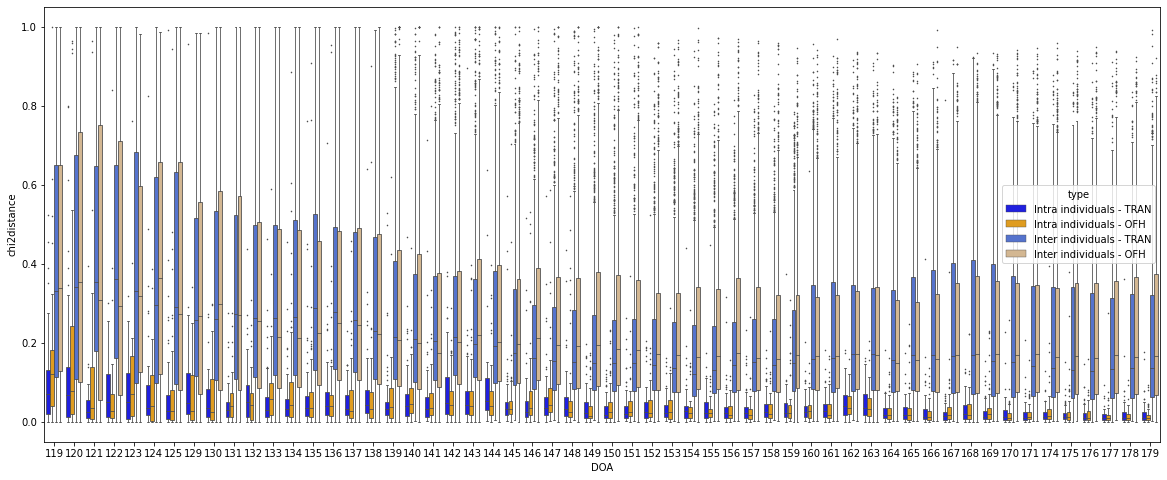

In [69]:
fig = plt.subplots(figsize=(20,8)) 
print(df_chi2.shape)
print(df_chi2[(df_chi2['henID1'].isin(li_hen_more50days))&(df_chi2['henID2'].isin(li_hen_more50days))].shape)
hue_order = ['Intra individuals - TRAN','Intra individuals - OFH','Inter individuals - TRAN','Inter individuals - OFH']
sns.boxplot(x="DOA", y="chi2distance", hue="type", data=df_chi2[(df_chi2['henID1'].isin(li_hen_more50days))&\
                                                                (df_chi2['henID2'].isin(li_hen_more50days))], 
            linewidth=0.8, fliersize=0.7, palette = pal_interintre_treatment, hue_order=hue_order);
plt.savefig(os.path.join(path_extracted_data_visual_adap,'chi2distance_inter&intra_individual_pertreatment_DOA.png')#,
            dpi=300,format='png',bbox_inches='tight')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


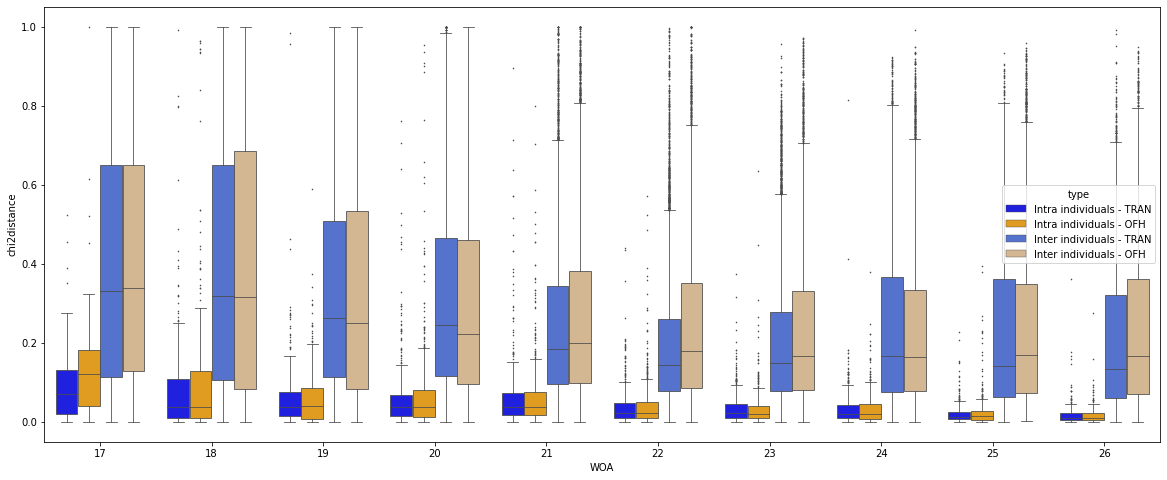

In [70]:
fig = plt.subplots(figsize=(20,8)) 
hue_order = ['Intra individuals - TRAN','Intra individuals - OFH','Inter individuals - TRAN','Inter individuals - OFH']
sns.boxplot(x="WOA", y="chi2distance", hue="type", data=df_chi2[(df_chi2['henID1'].isin(li_hen_more50days))&\
                                                                (df_chi2['henID2'].isin(li_hen_more50days))], 
            linewidth=0.8, fliersize=0.7, palette = pal_interintre_treatment, hue_order=hue_order);
plt.savefig(os.path.join(path_extracted_data_visual_adap,'chi2distance_inter&intra_individual_pertreatment_WOA.png'),
            dpi=300,format='png',bbox_inches='tight')

fig = plt.subplots(figsize=(20,8)) 
sns.boxplot(x="DOA", y="chi2distance", hue="Treatment", data=df_daily[df_daily['DOA']<=160], linewidth=0.7, fliersize=0.6,
            hue_order=['TRAN','OFH'], palette=pal_treat)
plt.savefig(os.path.join(path_extracted_data_visual_treatmentclass,'chi2distance_intra_individual_treatment_DOA.png'),
            dpi=300,format='png',bbox_inches='tight') 

#fig, ax = plt.subplots(figsize=(15,8)) 
#WOA as we have loads of days missing for some pens, and  as similarity depends on two consecutives days, DOA is not oke
#ISSUE: check impact of missing days and impac of WG opening!! on the 8th: 127 DOA
sns.boxplot(x="WOA", y="chi2distance", hue="Treatment", data=df_daily, linewidth=0.7, fliersize=0.6,
           hue_order=['TRAN','OFH'], palette=pal_treat);
plt.savefig(os.path.join(path_extracted_data_visual_treatmentclass,'chi2distance_intra_individual_treatment_WOA.png'),
            dpi=300,format='png',bbox_inches='tight') 

# % hens not moving

In [80]:
#min number of birds that must represent a single point
nbr_min_bird = 10

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(118, 4)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,DOA,Treatment,Total_number_transition,nbr_birds


(118, 4)


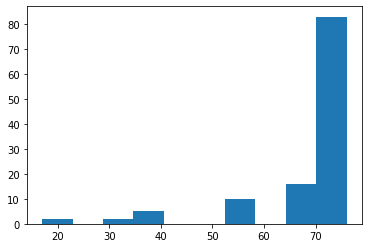

,DOA,Treatment,Total_number_transition,nbr_birds,Percentage not moving
0,119,OFH,"[6.0, 2.0, 5.0, 26.0, 21.0, 14.0, 52.0, 19.0, ...",33,3.030303
1,119,TRAN,"[5.0, 13.0, 5.0, 6.0, 18.0, 29.0, 20.0, 12.0, ...",32,6.250000
2,120,OFH,"[2.0, 17.0, 14.0, 22.0, 8.0, 10.0, 0.0, 20.0, ...",70,20.000000


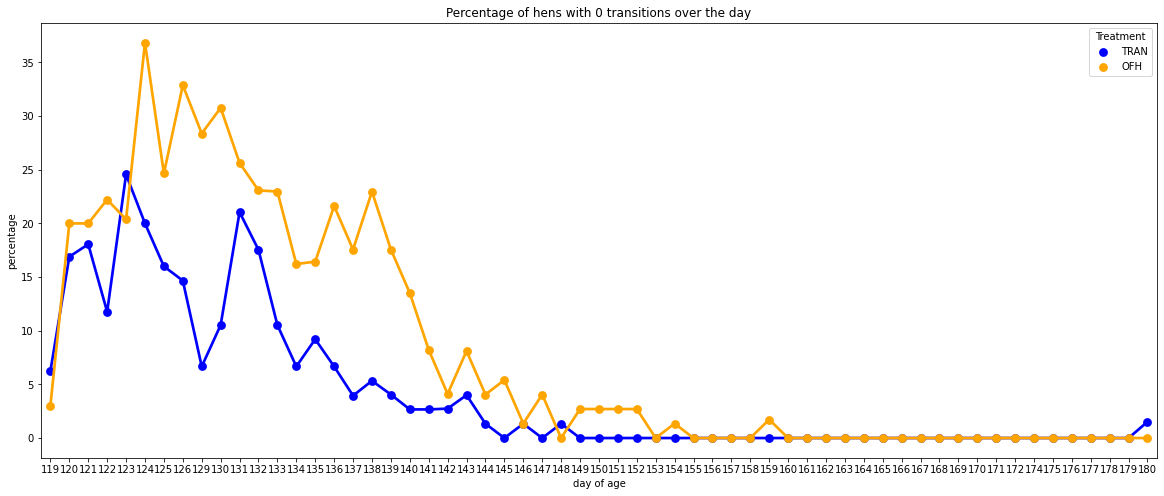

In [81]:
#simple barplot (sorted with x values)
df_plt = df_daily[df_daily['HenID'].isin(li_hen_more50days)][['DOA','Treatment','Total_number_transition']].copy()
df_plt = df_plt[~df_plt.isnull().any(axis=1)]
df_plt = df_plt.groupby(['DOA','Treatment'])['Total_number_transition'].agg(lambda x: list(x)).reset_index()
df_plt['nbr_birds'] = df_plt['Total_number_transition'].map(lambda x: len(x))
#take only when there is at least x birds in the the point
print(df_plt.shape)
display(df_plt[df_plt['nbr_birds']<nbr_min_bird])
df_plt = df_plt[df_plt['nbr_birds']>=nbr_min_bird]
print(df_plt.shape)
plt.hist(df_plt['nbr_birds'].tolist())
plt.show()
df_plt['Percentage not moving'] = df_plt['Total_number_transition'].map(lambda x: sum([i==0 for i in x])/len(x)*100)
display(df_plt.head(3))
df_plt.sort_values(['DOA'], inplace=True)
fig = plt.subplots(figsize=(20,8)) 
sns.pointplot(x="DOA", y="Percentage not moving", data=df_plt, hue='Treatment', hue_order=['TRAN','OFH'],
                 palette=pal_treat, alpha=0.7)
#ax.set_xticklabels(ax.get_xticklabels(), fontsize=5)
plt.title('Percentage of hens with 0 transitions over the day')
plt.ylabel('percentage')
plt.xlabel('day of age')
plt.savefig(os.path.join(path_extracted_data_visual_adap, 'Barplot%Hens0Transition_per_treatment.png'),dpi=300,format='png',bbox_inches='tight')

(118, 4)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,DOA,CLASS,Total_number_transition,nbr_birds


(118, 4)


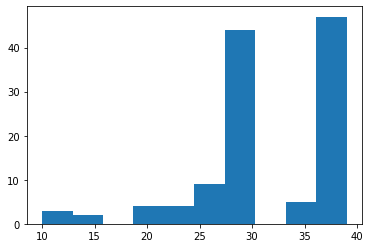

,DOA,CLASS,Total_number_transition,nbr_birds,Percentage not moving
0,119,LEXP,"[6.0, 20.0, 14.0, 7.0, 33.0, 17.0, 20.0, 4.0, ...",10,0.000000
1,119,MEXP,"[13.0, 12.0, 21.0, 14.0, 52.0, 19.0, 7.0, 13.0...",22,9.090909
2,120,LEXP,"[26.0, 43.0, 26.0, 2.0, 16.0, 18.0, 27.0, 4.0,...",25,12.000000


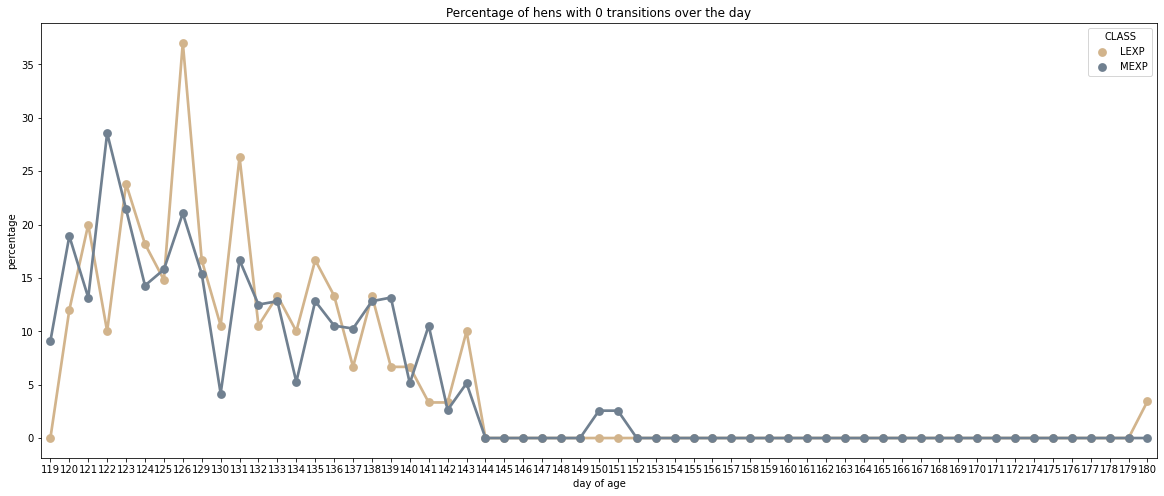

In [82]:
#simple barplot (sorted with x values)
df_plt = df_daily[df_daily['CLASS'].isin(['LEXP','MEXP'])&(df_daily['HenID'].isin(li_hen_more50days))][['DOA','CLASS','Total_number_transition']].copy()
df_plt = df_plt[~df_plt.isnull().any(axis=1)]
df_plt = df_plt.groupby(['DOA','CLASS'])['Total_number_transition'].agg(lambda x: list(x)).reset_index()
df_plt['nbr_birds'] = df_plt['Total_number_transition'].map(lambda x: len(x))
#take only when there is at least x birds in the the point
print(df_plt.shape)
display(df_plt[df_plt['nbr_birds']<nbr_min_bird])
df_plt = df_plt[df_plt['nbr_birds']>=nbr_min_bird]
print(df_plt.shape)
plt.hist(df_plt['nbr_birds'].tolist())
plt.show()
df_plt['Percentage not moving'] = df_plt['Total_number_transition'].map(lambda x: sum([i==0 for i in x])/len(x)*100)
display(df_plt.head(3))
df_plt.sort_values(['DOA'], inplace=True)
fig = plt.subplots(figsize=(20,8)) 
sns.pointplot(x="DOA", y="Percentage not moving", data=df_plt, hue='CLASS', 
             hue_order=['LEXP','MEXP'], palette=pal_class, alpha=0.7)
#ax.set_xticklabels(ax.get_xticklabels(), fontsize=5)
plt.title('Percentage of hens with 0 transitions over the day')
plt.ylabel('percentage')
plt.xlabel('day of age')
plt.savefig(os.path.join(path_extracted_data_visual_adap, 'Barplot%Hens0Transition_per_CLASS.png'),dpi=300,format='png',bbox_inches='tight')

# Specifics' zones usage similarity across days

In [75]:
#for being more reproductible, we open the file that was saved from cleaning
df = pd.read_csv(os.path.join(path_extracted_data, id_run+'_CLEANEDDATA.csv'), sep=';', parse_dates=['Timestamp', 'date']) 
df = df[df['Timestamp']<=dt.datetime(2020,11,30)]
df['hour'] = df['Timestamp'].map(lambda x: x.hour)
df['time'] = df['Timestamp'].map(lambda x: dt.datetime.time(x-dt.timedelta(seconds=x.second)))
df.drop('duration', axis=1, inplace=True)
print(df.shape)
df.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(406521, 15)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open
0,hen_111,pen11,10 - 12,3_Zone,1.0,2020-09-30 00:01:25,2020-09-30,2020-09-30 00:01:38.000,NaN,NaN,2_Zone,NaN,NaN,False,False
1,hen_111,pen11,10 - 12,2_Zone,1.0,2020-09-30 00:01:38,2020-09-30,2020-09-30 00:14:38.000,2020-09-30 00:01:25.000,0 days 00:00:13,2_Zone,3_Zone,NaN,False,False
2,hen_147,pen8,8 - 9,5_Zone,1.0,2020-09-30 00:30:49,2020-09-30,2020-09-30 00:33:26.000,NaN,NaN,5_Zone,NaN,NaN,False,False


In [22]:
nbr_nestboxmn = 10
df.sort_values(['Timestamp'], inplace=True)
li_df = []
df_doa = df_daily[['level','DOA','WOA']].drop_duplicates()
for p, df_pen in tqdm.tqdm(df.groupby('PenID')):
    #compute time series
    df_ts = time_series_henColumn_tsRow(df_pen, config, col_ts='Zone', ts_with_all_hen_value=False, save=False, 
                                        hen_time_series=False)
    #reduce to the interval we want
    mi = min(df_ts['Timestamp'].tolist())
    ma = max(df_ts['Timestamp'].tolist())
    Daterange = pd.date_range(start = mi-dt.timedelta(seconds=mi.second)-dt.timedelta(minutes=mi.minute), 
                              end = ma+dt.timedelta(seconds=60-ma.second), 
                              freq = str(nbr_nestboxmn)+'MIN')    
    df_date = pd.DataFrame({str(nbr_nestboxmn)+'mn_timestamp':Daterange})
    new_timestamp = str(nbr_nestboxmn)+'mn_timestamp'
    df_date[new_timestamp] = df_date[new_timestamp].map(lambda x: pd.to_datetime(x))
    df_ts = pd.merge_asof(df_ts, df_date, left_on=['Timestamp'], right_on=[new_timestamp], direction='forward')
    #groupby the interval that we want with the number of minutes in nestbox
    li_hen = [v for v in df_ts.columns if 'hen_' in v]
    for ZONE in df['Zone'].unique():
        print(ZONE)
        df_nestbox = df_ts.groupby(new_timestamp)[li_hen].agg(lambda x: sum([i==ZONE for i in x])/60).reset_index()
        df_nestbox['date'] = df_nestbox[new_timestamp].map(lambda x: dt.datetime(x.year,x.month,x.day))

        #groupby date for simplicity
        df_nestbox = df_nestbox.groupby('date')[li_hen].agg(lambda x: list(x)).reset_index()
        #print(df_nestbox.shape)
        #display(df_nestbox.head(3))

        li_date = set(df_pen['date'].tolist())
        for d1 in sorted(list(li_date)):
            #dont do if the date have is a disturbance day
            if d1 in df_doa['level'].unique():
                doa = df_doa[df_doa['level']==d1]['DOA'].values[0]
                woa = df_doa[df_doa['level']==d1]['WOA'].values[0]
                d2 = d1+dt.timedelta(days=1)
                #dont do if the date have is a disturbance day or is not in the dataframe (e.g last day)
                if (d2 in df_doa['level'].unique())& (d2 in li_date):            
                    li_hen_d1 = df_pen[df_pen['date']==d1]['HenID'].unique() #take only the birds with at least one transition during the day`!!
                    li_hen_d2 = df_pen[df_pen['date']==d2]['HenID'].unique()
                    #its a symmetric measure, so we only do each combination once
                    for h1 in li_hen_d1:
                        for h2 in li_hen_d2:
                            l1 = np.array(df_nestbox[df_nestbox['date']==d1][h1].values[0], dtype=np.double)
                            l2 = np.array(df_nestbox[df_nestbox['date']==d2][h2].values[0], dtype=np.double)    
                            #path = dtw.warping_path(s1, s2)
                            #dtwvis.plot_warping(s1, s2, path, filename="warp.png")
                            #d = dtw.distance_fast(s1, s2)
                            penalty = 0
                            window = int(30/nbr_nestboxmn)
                            #psi: number of start and end points of a sequence can be ignored if this would lead to a lower distance.
                            d, paths = dtw.warping_paths(l1, l2, window=window, psi=0, penalty=penalty) #, max_step=0
                            dico_ = {'henID1':h1, 'henID2':h2, 'level':d1, 'level+1':d2, 'PenID':p, 'Treatment':dico_pen_tr[p],
                                     'DOA':doa, 'WOA':woa,
                                     'DTW':int(round(d,0)),'li1':l1, 'li2':l2, 'window':int(30/nbr_nestboxmn), penalty:penalty, 'Zone':ZONE}                 
                            li_df.append(dico_)
df_nestbox_sim = pd.DataFrame(li_df)
#df_chi2 = df_chi2[~df_chi2['chi2distance'].isnull()]
df_nestbox_sim['is_same_ind'] = df_nestbox_sim.apply(lambda x: x['henID1']==x['henID2'], axis=1)
df_nestbox_sim = df_nestbox_sim.sort_values('DOA', ascending=True)
dico_name = {True: 'Intra individuals', False:'Inter individuals'}
df_nestbox_sim['type'] = df_nestbox_sim.apply(lambda x: dico_name[x['is_same_ind']]+' - '+x['Treatment'], axis=1)
df_nestbox_sim['HenID1_CLASS'] = df_nestbox_sim['henID1'].map(lambda x: df_FB[df_FB['HenID']==x]['CLASS'].values[0])
df_nestbox_sim['HenID2_CLASS'] = df_nestbox_sim['henID2'].map(lambda x: df_FB[df_FB['HenID']==x]['CLASS'].values[0])
df_nestbox_sim['CLASS'] = df_nestbox_sim.apply(lambda x:x['HenID1_CLASS']+''+x['HenID2_CLASS'], axis=1)
df_nestbox_sim['CLASS'] = df_nestbox_sim['CLASS'].replace('MEXPMEXP','MEXP')
df_nestbox_sim['CLASS'] = df_nestbox_sim['CLASS'].replace('LEXPLEXP','LEXP')
df_nestbox_sim.drop(['li1','li2'], axis=1).to_csv(os.path.join(path_extracted_data_visual_adap, 
                                        id_run+'_df_zones_dtw_WITHOUTlist'+str(nbr_nestboxmn)+'.csv'), sep=';', index=False)
print('lets save with the list')
df_nestbox_sim.to_csv(os.path.join(path_extracted_data_visual_adap ,id_run+'_df_zones_dtw_'+str(nbr_nestboxmn)+'.csv'), 
                      sep=';', index=False)
print(df_nestbox_sim.shape)
df_nestbox_sim.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'df' is not defined

### visual

In [87]:
nbr_nestboxmn = 10
df_nestbox_sim = pd.read_csv(os.path.join(path_extracted_data_visual_adap, 
                                          id_run+'_df_zones_dtw_WITHOUTlist'+str(nbr_nestboxmn)+'.csv'), 
                             sep=';', parse_dates=['level'], dayfirst=True)
print(df_nestbox_sim.shape)
df_nestbox_sim = df_nestbox_sim[(df_nestbox_sim['henID1'].isin(li_hen_more50days))&\
                                (df_nestbox_sim['henID2'].isin(li_hen_more50days))]
print(df_nestbox_sim.shape)
df_nestbox_sim.head(3)

(748560, 17)
(655815, 17)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,henID1,henID2,level,level+1,PenID,Treatment,DOA,WOA,DTW,window,0,Zone,is_same_ind,type,HenID1_CLASS,HenID2_CLASS,CLASS
0,hen_67,hen_46,2020-09-30,2020-10-01,pen10,TRAN,119,17,31,3,0,3_Zone,False,Inter individuals - TRAN,MEXP,EPI,MEXPEPI
1,hen_126,hen_151,2020-09-30,2020-10-01,pen8,TRAN,119,17,55,3,0,5_Zone,False,Inter individuals - TRAN,EPI,MEXP,EPIMEXP
2,hen_126,hen_158,2020-09-30,2020-10-01,pen8,TRAN,119,17,82,3,0,5_Zone,False,Inter individuals - TRAN,EPI,MEXP,EPIMEXP


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


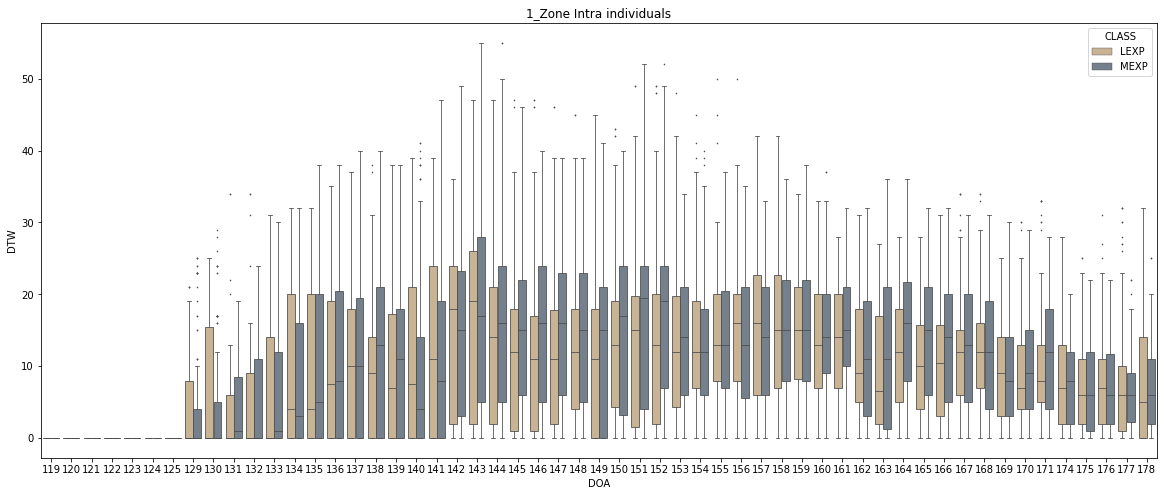

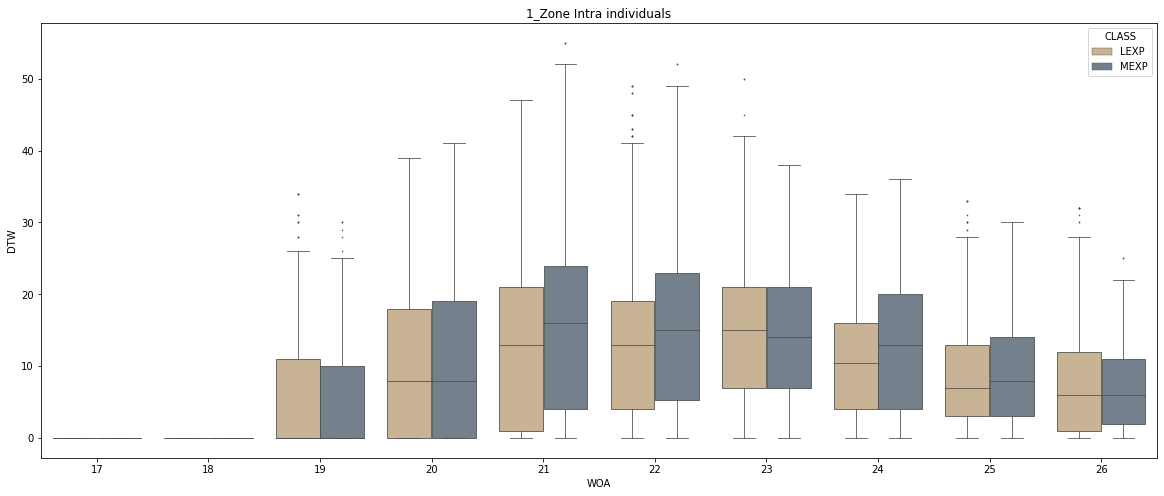

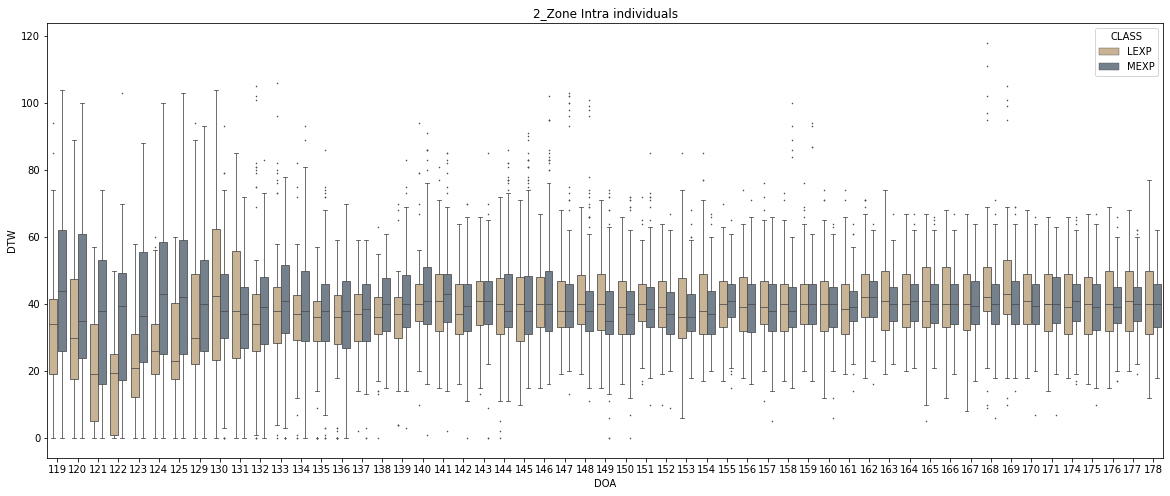

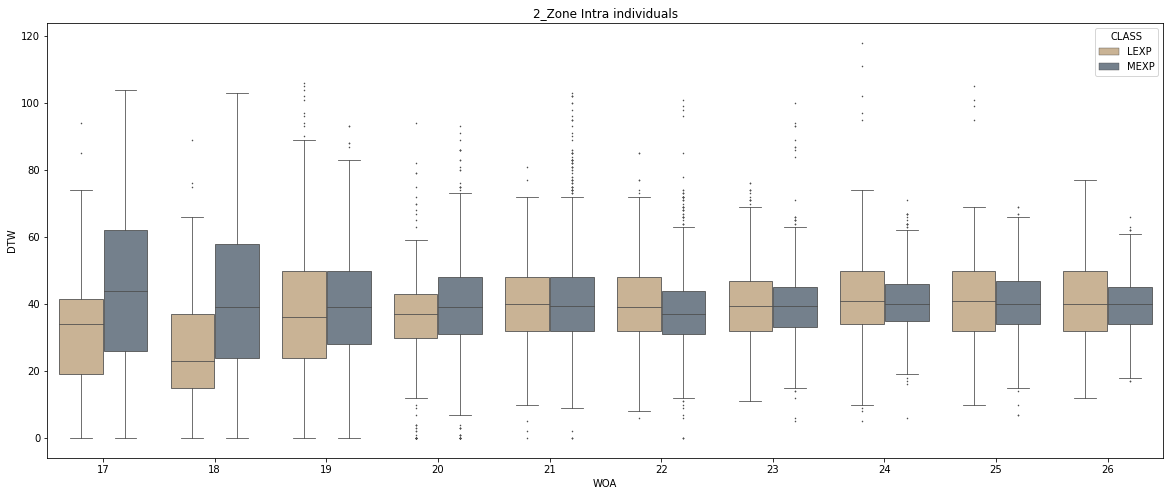

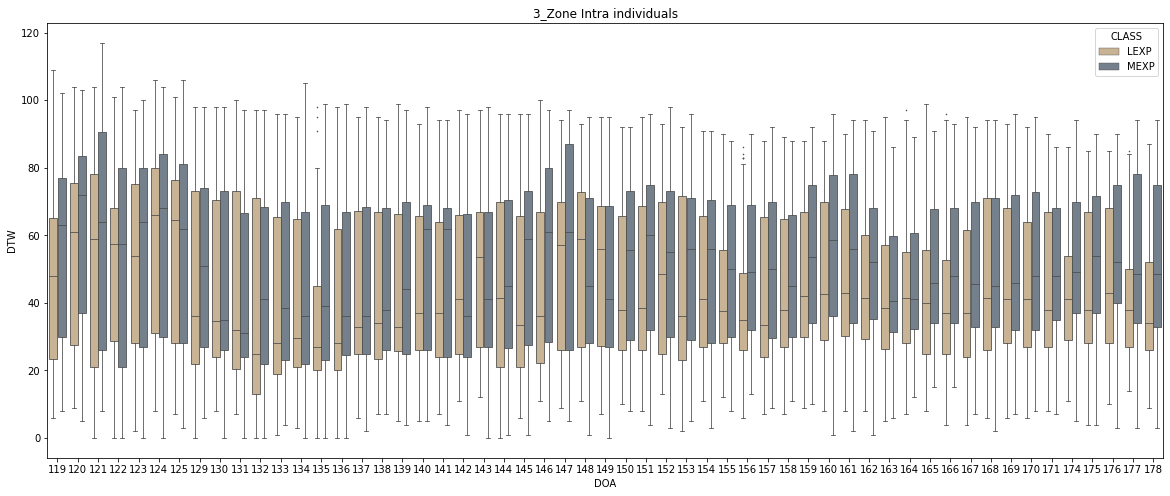

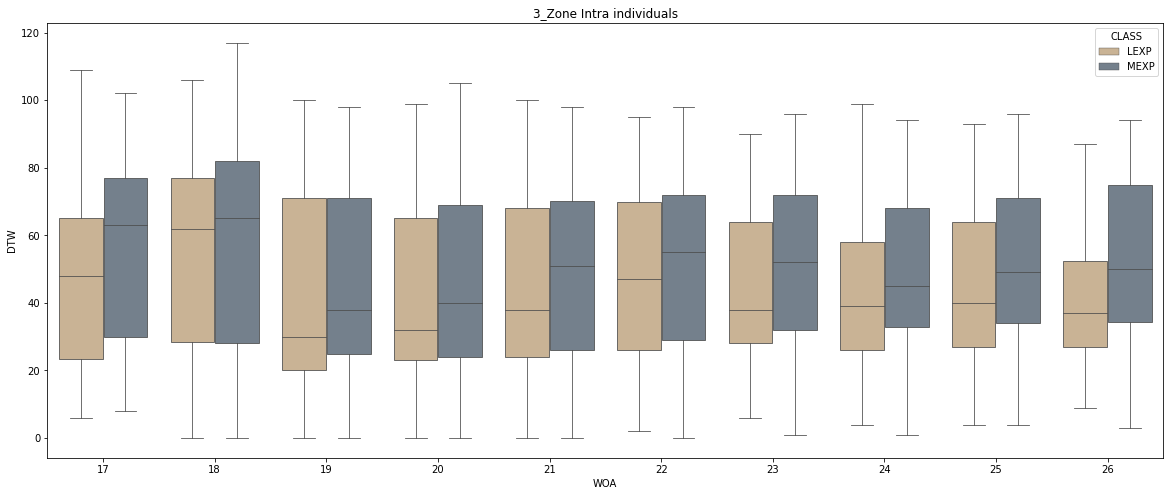

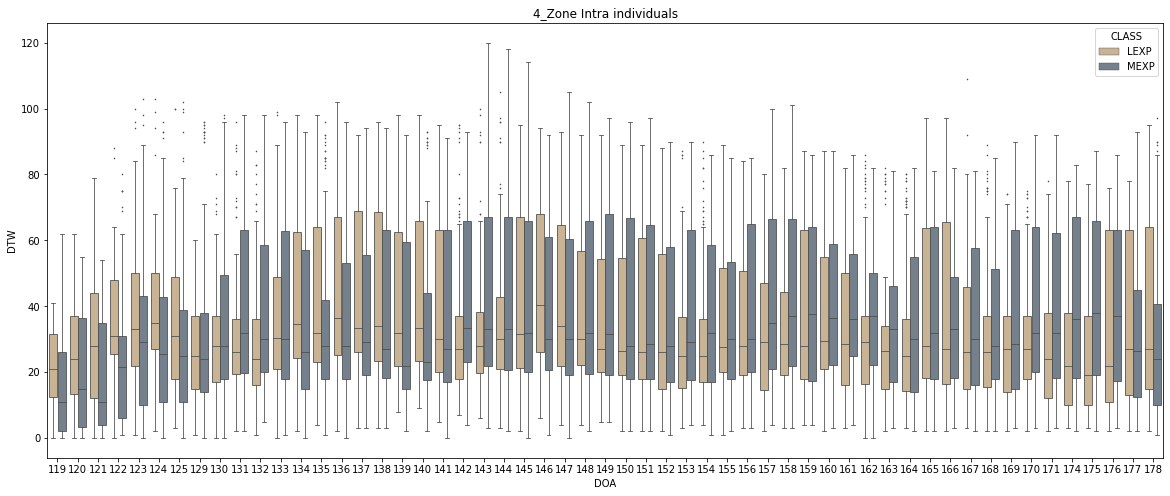

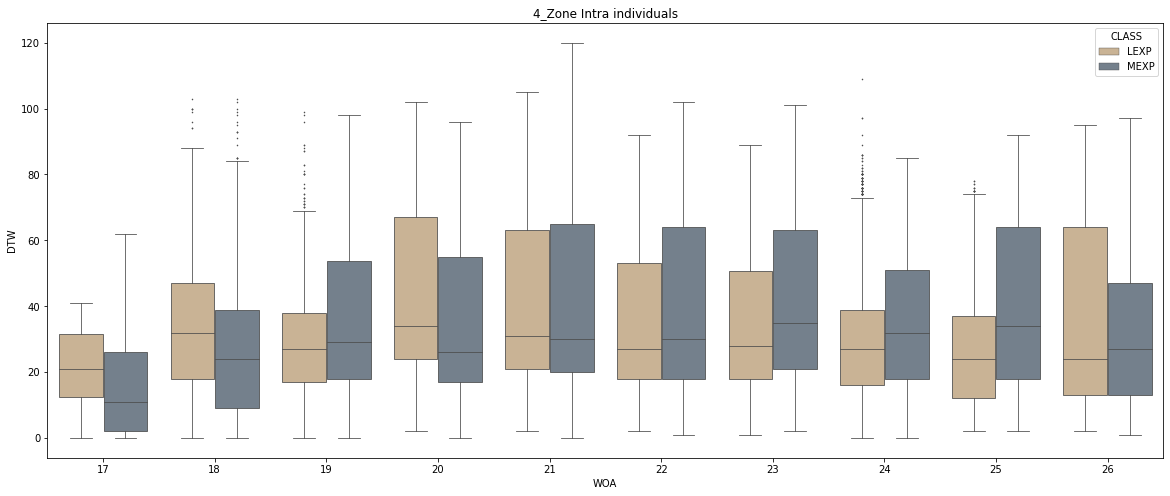

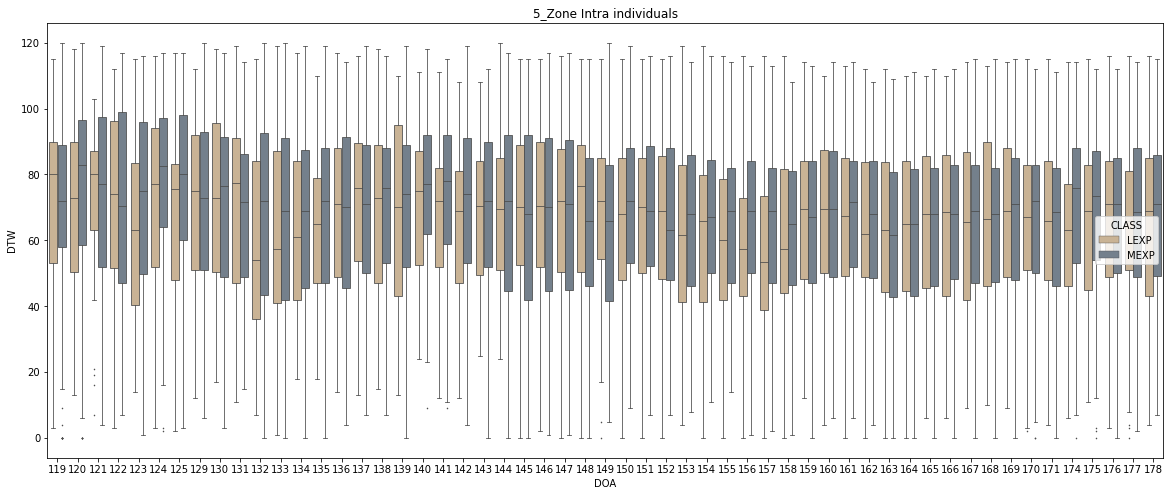

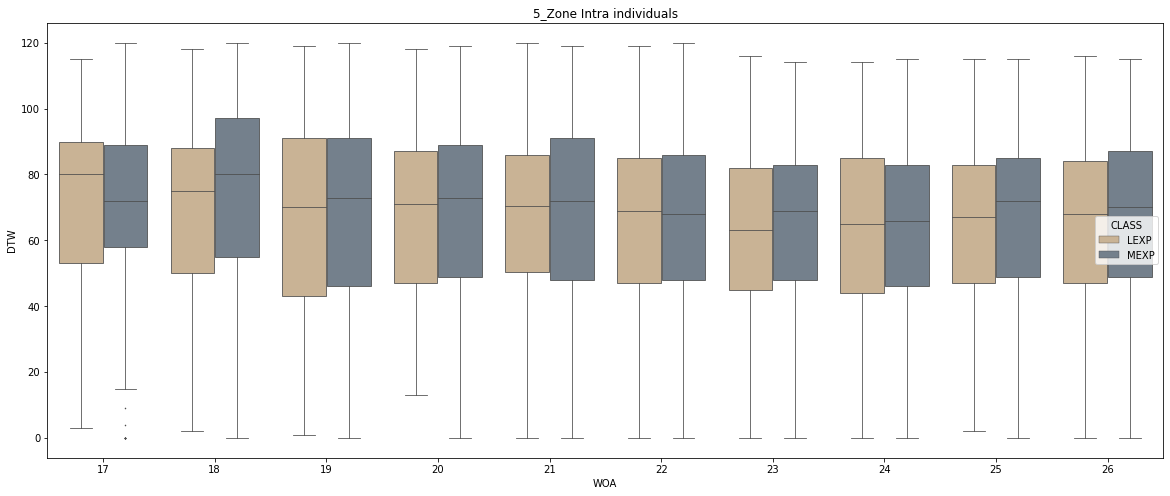

In [88]:
for z, df_plt in df_nestbox_sim.groupby('Zone'):
    hue_order = ['LEXP', 'MEXP']
    for t in ['DOA','WOA']:
        fig = plt.subplots(figsize=(20,8)) 
        sns.boxplot(x=t, y="DTW",  data=df_plt[df_plt['CLASS'].isin(['MEXP','LEXP'])], linewidth=0.8, fliersize=0.7, hue="CLASS", 
                    palette=pal_class, hue_order=hue_order);
        plt.title(z +' Intra individuals')
        plt.savefig(os.path.join(path_extracted_data_visual_adap,'DTW_inter&intra_individual_perclass_'+z+'_'+t+'.png'),
                    dpi=300,format='png',bbox_inches='tight')
        plt.show()

for z, df_plt in df_nestbox_sim[df_nestbox_sim['type'].isin(['Intra individuals - TRAN','Intra individuals - OFH'])].groupby('Zone'):
    print(z)
    for t in ['WOA']:
        for penID, df_plt_ in tqdm.tqdm(df_plt.groupby(['PenID'])):
            fig = plt.subplots(figsize=(10,5)) 
            sns.lineplot(x=t, y="DTW",  data=df_plt_, linewidth=0.8, hue="henID1");
            plt.title(z+'_'+penID)
            #plt.savefig(os.path.join(path_extracted_data_visual_adap,'DTW_inter&intra_individual_pertreatment_'+z+'_'+t+'.png'),
            #            dpi=300,format='png',bbox_inches='tight')
            plt.show()
        sys.exit()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


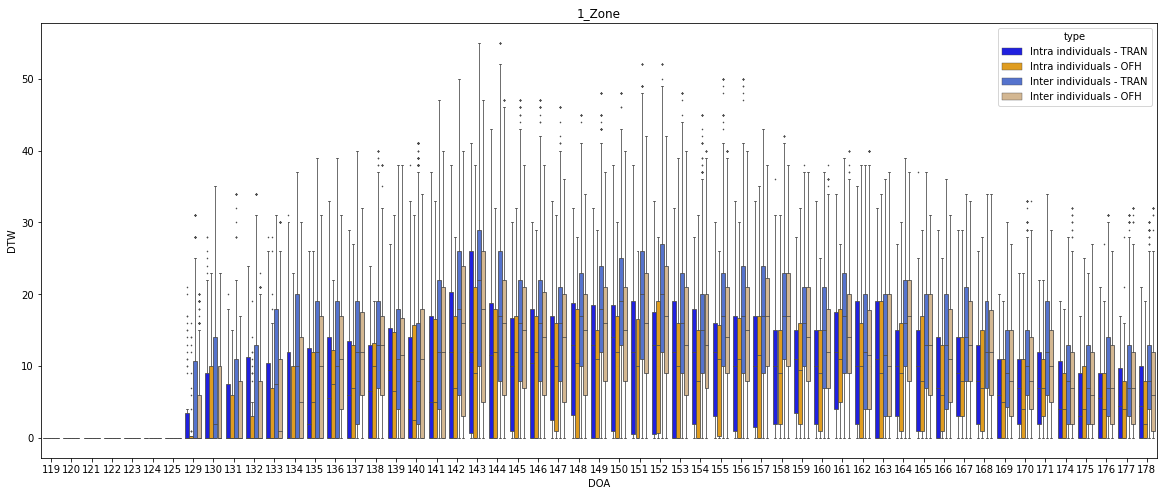

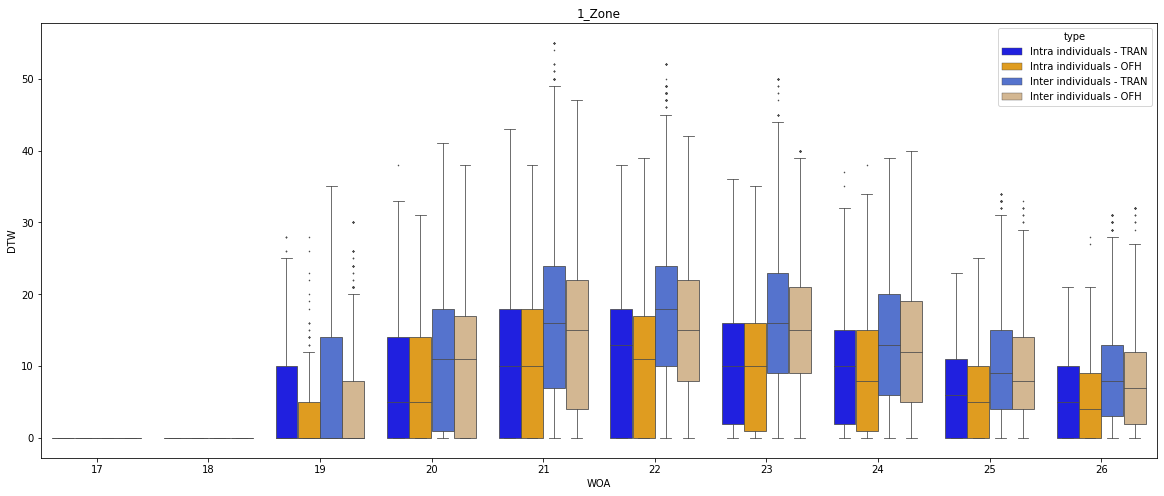

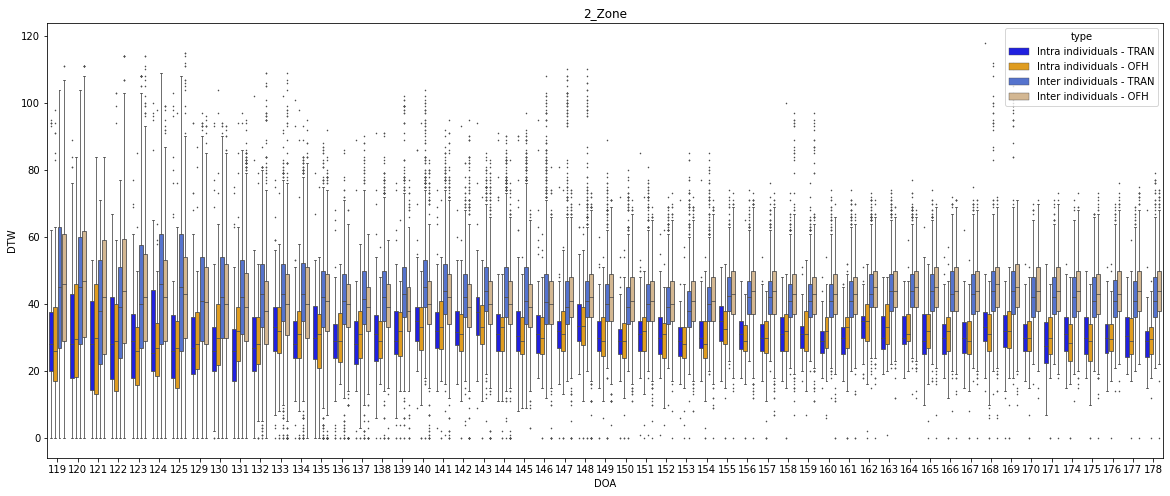

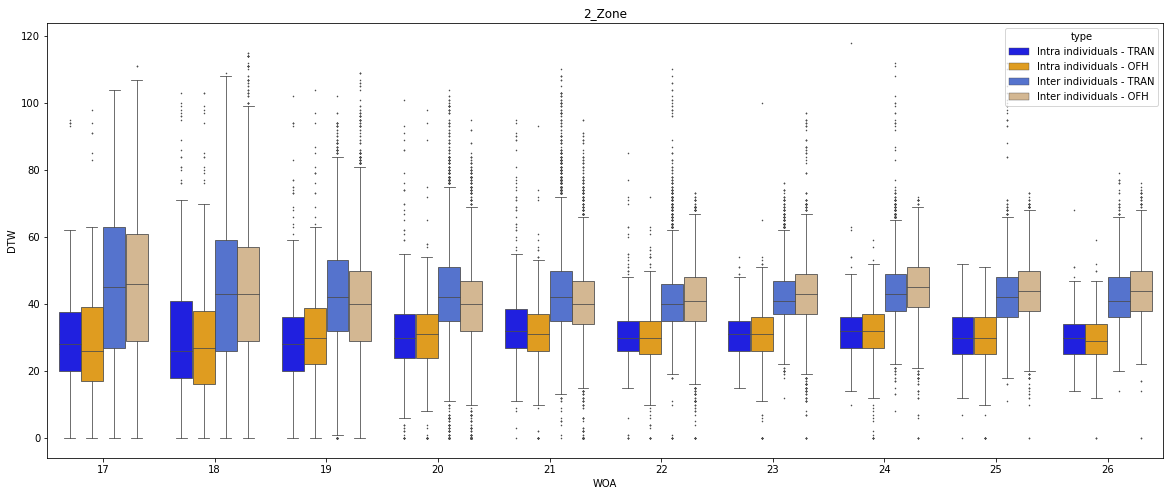

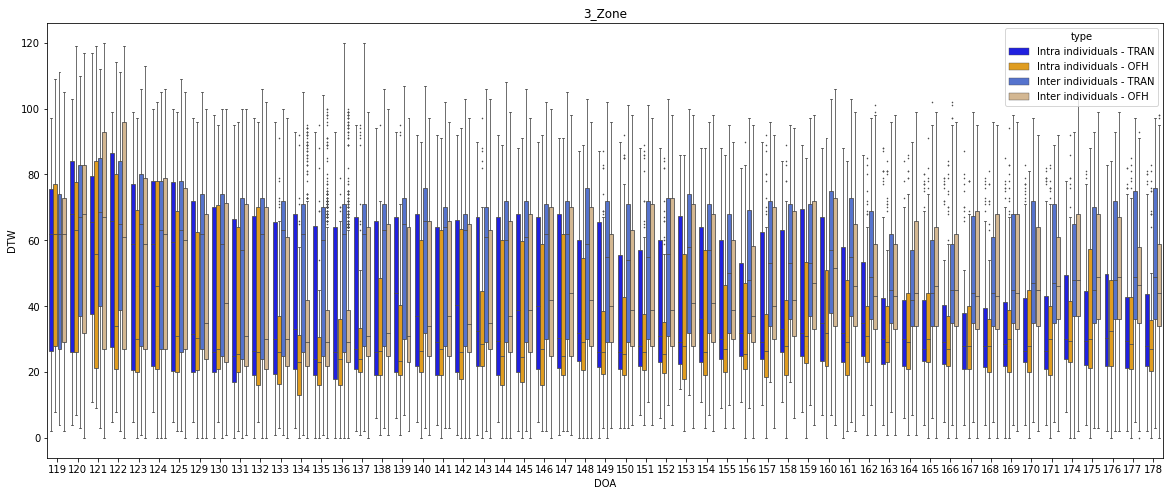

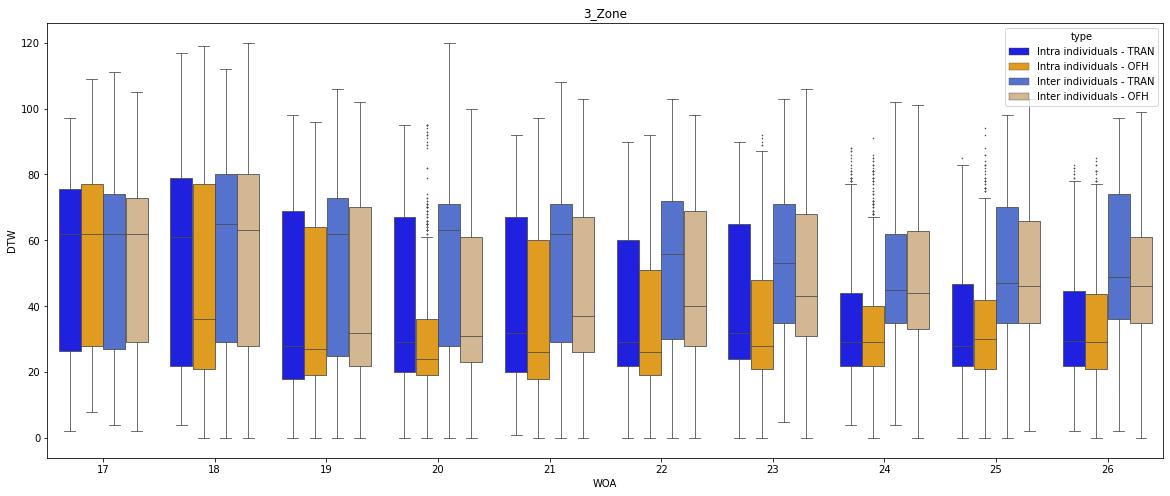

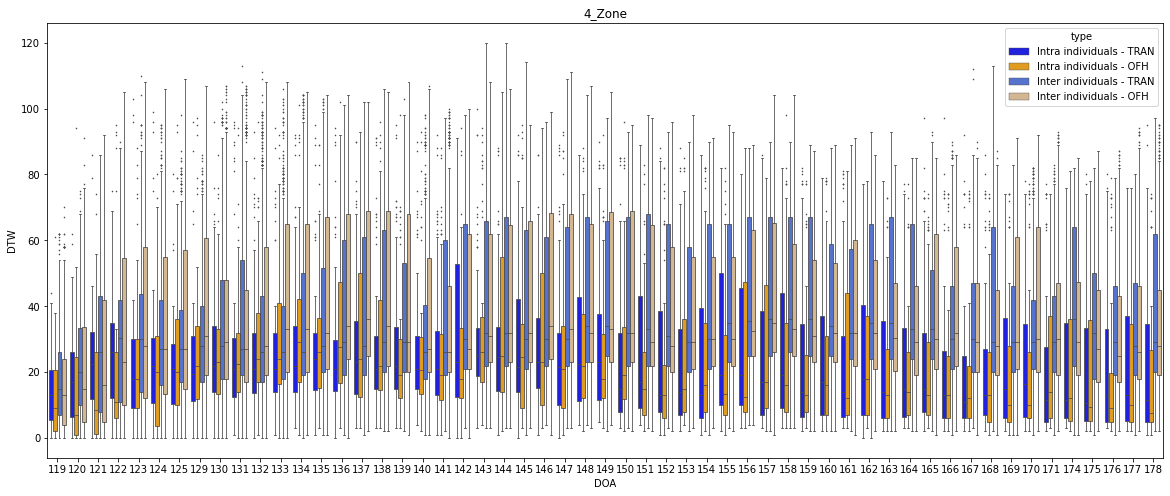

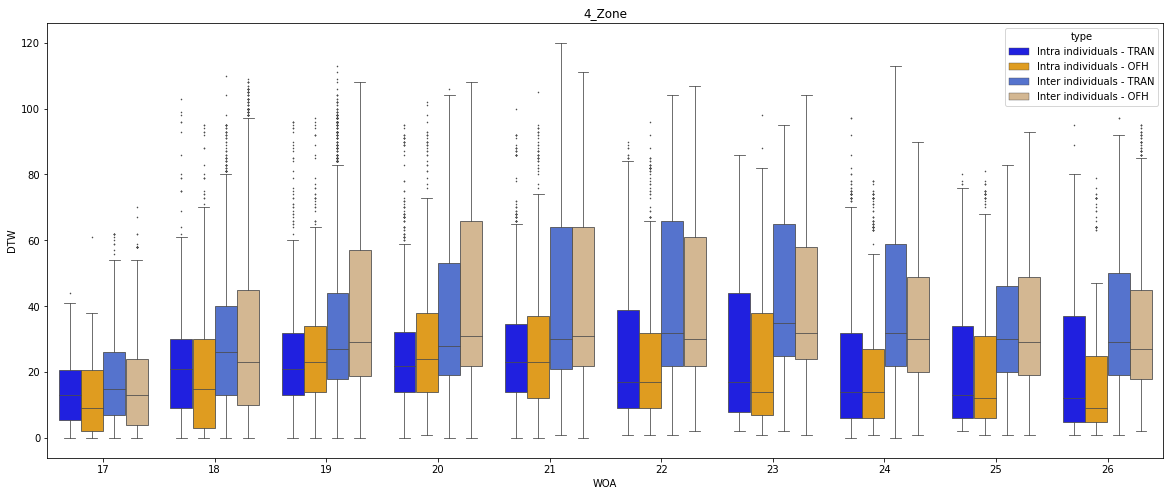

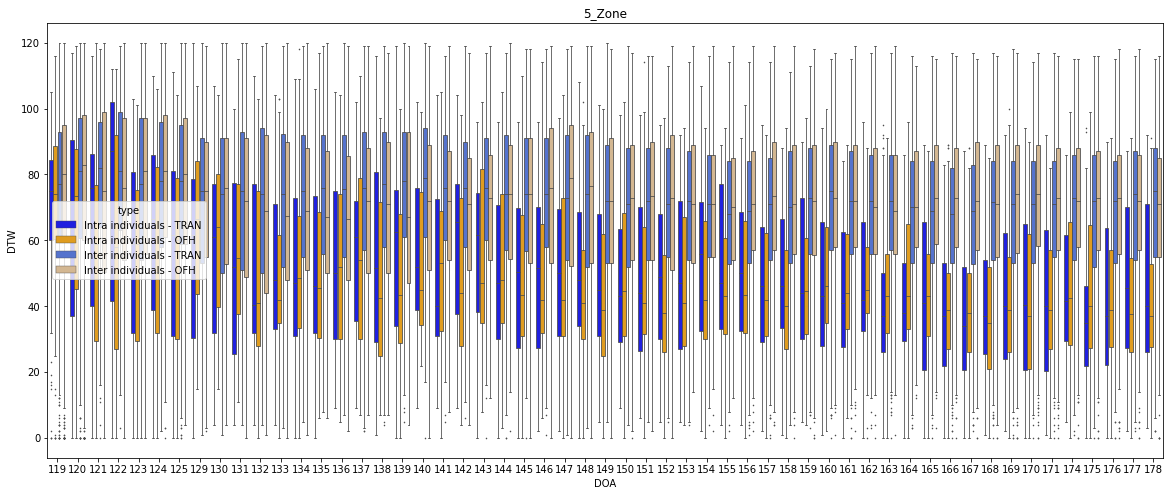

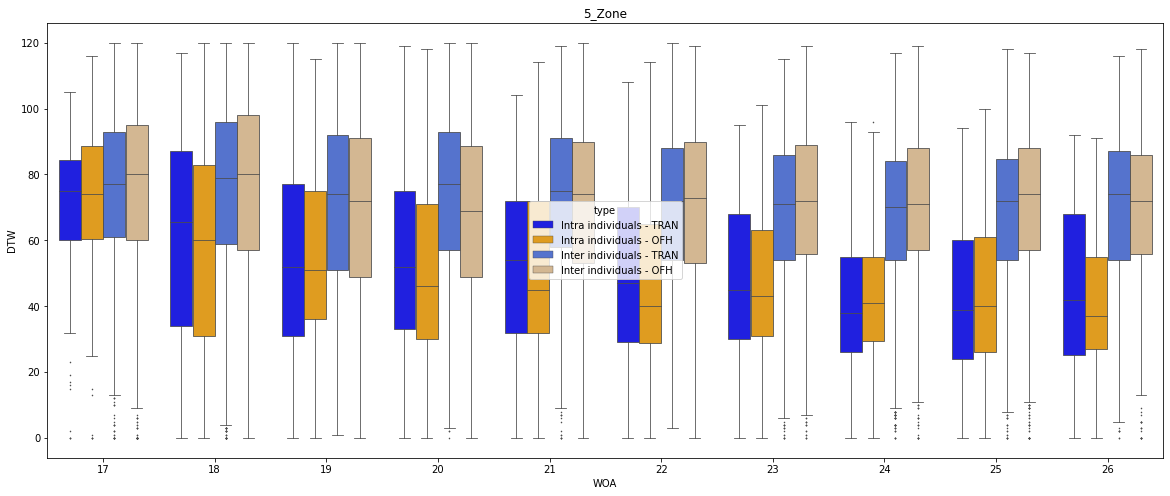

In [89]:
for z, df_plt in df_nestbox_sim.groupby('Zone'):
    hue_order = ['Intra individuals - TRAN','Intra individuals - OFH','Inter individuals - TRAN','Inter individuals - OFH']
    for t in ['DOA','WOA']:
        fig = plt.subplots(figsize=(20,8)) 
        sns.boxplot(x=t, y="DTW",  data=df_plt, linewidth=0.8, fliersize=0.7, hue="type", palette=pal_interintre_treatment, 
                    hue_order=hue_order);
        plt.title(z)
        plt.savefig(os.path.join(path_extracted_data_visual_adap,'DTW_inter&intra_individual_pertreatment_'+z+'_'+t+'.png'),
                    dpi=300,format='png',bbox_inches='tight')
        plt.show()

### test some DTW output

In [88]:
l1 = df_nestbox_sim.iloc[0]['li1']
l2 = df_nestbox_sim.iloc[0]['li2']

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
d, p = dtw.warping_paths(l1, l2, window=window, psi=0, penalty=penalty)
print(d)

30.76761013360208


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|                                                                           | 20/748560 [00:07<70:45:11,  2.94it/s]<ipython-input-106-9843748ff96d>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15,5))
  0%|                                                                          | 651/748560 [03:54<74:46:39,  2.78it/s]


KeyboardInterrupt: 

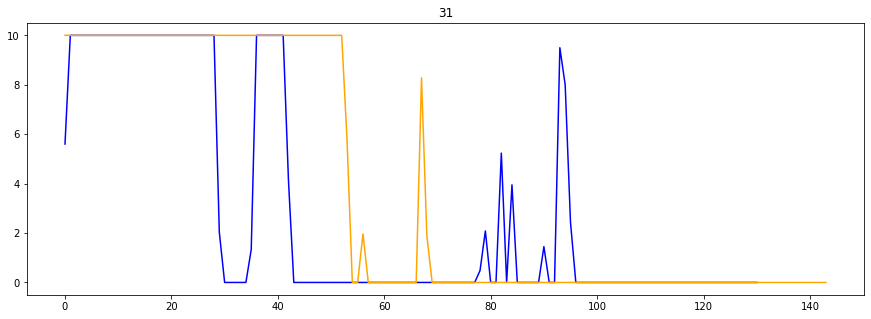

Error in callback <function flush_figures at 0x0000027A7A4F0E50> (for post_execute):


KeyboardInterrupt: 

In [106]:
for i in tqdm.tqdm(range(df_nestbox_sim.shape[0])):
    fig = plt.figure(figsize=(15,5))
    x = df_nestbox_sim.iloc[i]
    l1 = x['li1']
    l2 = x['li2']
    h1 = x['henID1']
    h2 = x['henID2']
    d = x['DTW']
    plt.plot(l1, color='blue')
    plt.plot(l2, color='orange')
    plt.title(d)
    plt.savefig(os.path.join(path_extracted_data_visual_adap_verification,str(d)+'_'+h1+'_'+h2+'.png'),
                dpi=300,format='png',bbox_inches='tight')

### nbr transitions per birds per 5 mn (disturbance days?)

In [ ]:
#nbr of transitions per chicken, per hour of the day
df['time'] = df['Timestamp'].map(lambda x: (x.minute*60+x.hour*60*60)/(5*60))
df_plt = df.groupby(['date','time','HenID'])['Timestamp'].agg(lambda x: len(list(x))).reset_index()
print(df_plt.shape)
display(df_plt.head(3))
#barn cleaning on thursday: first time cleaning of the barn: 8.10.2020 (i was tehre, was impressive! form 10h45 until 11h45)
fig = plt.figure(figsize=(15,5))
sns.lineplot(data=df_plt[df_plt['date']<=dt.datetime(2020,10,9)], x='time', y='Timestamp',hue='date')
#we dont see any days with abnormal amount of transitions

In [ ]:
#nbr of transitions per chicken, per hour of the day
df_plt = df.groupby(['date','hour','HenID'])['Timestamp'].agg(lambda x: len(list(x))).reset_index()
print(df_plt.shape)
display(df_plt.head(3))
#barn cleaning on thursday: 1.10.2020, 8.10.2020
fig = plt.figure(figsize=(15,5))
sns.lineplot(data=df_plt[df_plt['date']<=dt.datetime(2020,10,9)], x='hour', y='Timestamp',hue='date')
#we dont see any days with abnormal amount of transitions

# Behavioural difference

In [16]:
#we dont choose the transition as transitional zones are mmore likely, and for the adaptability study we have the birds not moving
#at all which will have 0 transitions: night_Total_number_transition: would need more verification
#not down_missingZone_mvtPerc as to many things but up_missingZone_mvtPerc as means efficient
#distribution_entropy: not as only will distinguish between birds having long stay in zone 4
#'TimeFirstVisitLonger15mn-TimeFirstVisit_mn': had to interpret as no real nestbox
#night_Max_duration_zones: def: where the hens staid the longest consecutively
#activity_xpercentile_sec not used as different horaire
#one model on night main zone!
li_all = ['percentage_time_outside_while_WG_open','perc_duration_2_Zone', 'perc_duration_3_Zone', 'perc_duration_4_Zone',
          'perc_duration_5_Zone',
         'in_WG_15mnAfterOpening','up_missingZone_mvtPerc','vertical_travel_distance','sucessIntrusion_9','is_max_nightzone_duration_zonelitterORlowerperch']
print(len(li_all))

10


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(9807, 4)


,HenID,DOA,is_max_nightzone_duration_zonelitterORlowerperch,Treatment
0,hen_130,123,False,TRAN
1,hen_130,124,False,TRAN
2,hen_130,125,True,TRAN


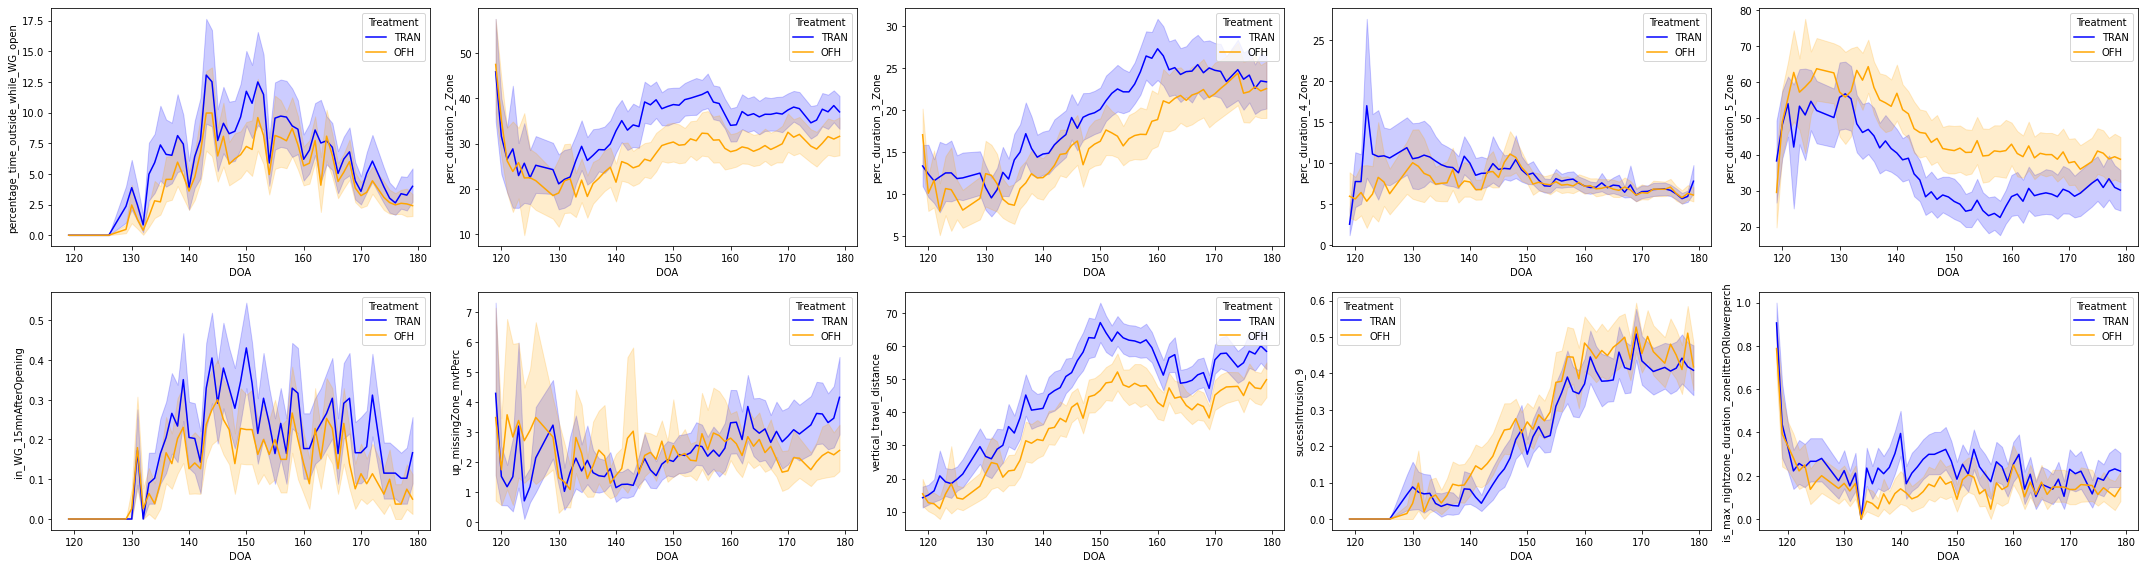

In [17]:
c = 5
l = math.ceil(len(li_all)/5) #round up
img_w = 6 
img_h = 4 
fig = plt.figure(figsize=(int(c*img_w), int(l*img_h)))
i = 1
for x in li_all:
    #print(x)
    plt.subplot(l,c,i)
    plt.tight_layout()
    df_plt = df_daily[['HenID','DOA',x,'Treatment']].copy()
    df_plt = df_plt[~df_plt.isnull().any(axis=1)]
    sns.lineplot(data=df_plt, x="DOA", y=x, hue='Treatment', palette=pal_treat, hue_order=['TRAN','OFH'])
    i = i+1
plt.savefig(os.path.join(path_extracted_data_visual_adap, 'Treatment_Adaptability.png'), bbox_inches='tight')
print(df_plt.shape)
display(df_plt.head(3))
plt.show();

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3965, 4)


,HenID,DOA,is_max_nightzone_duration_zonelitterORlowerperch,CLASS
118,hen_134,120,False,MEXP
119,hen_134,121,True,MEXP
120,hen_134,123,False,MEXP


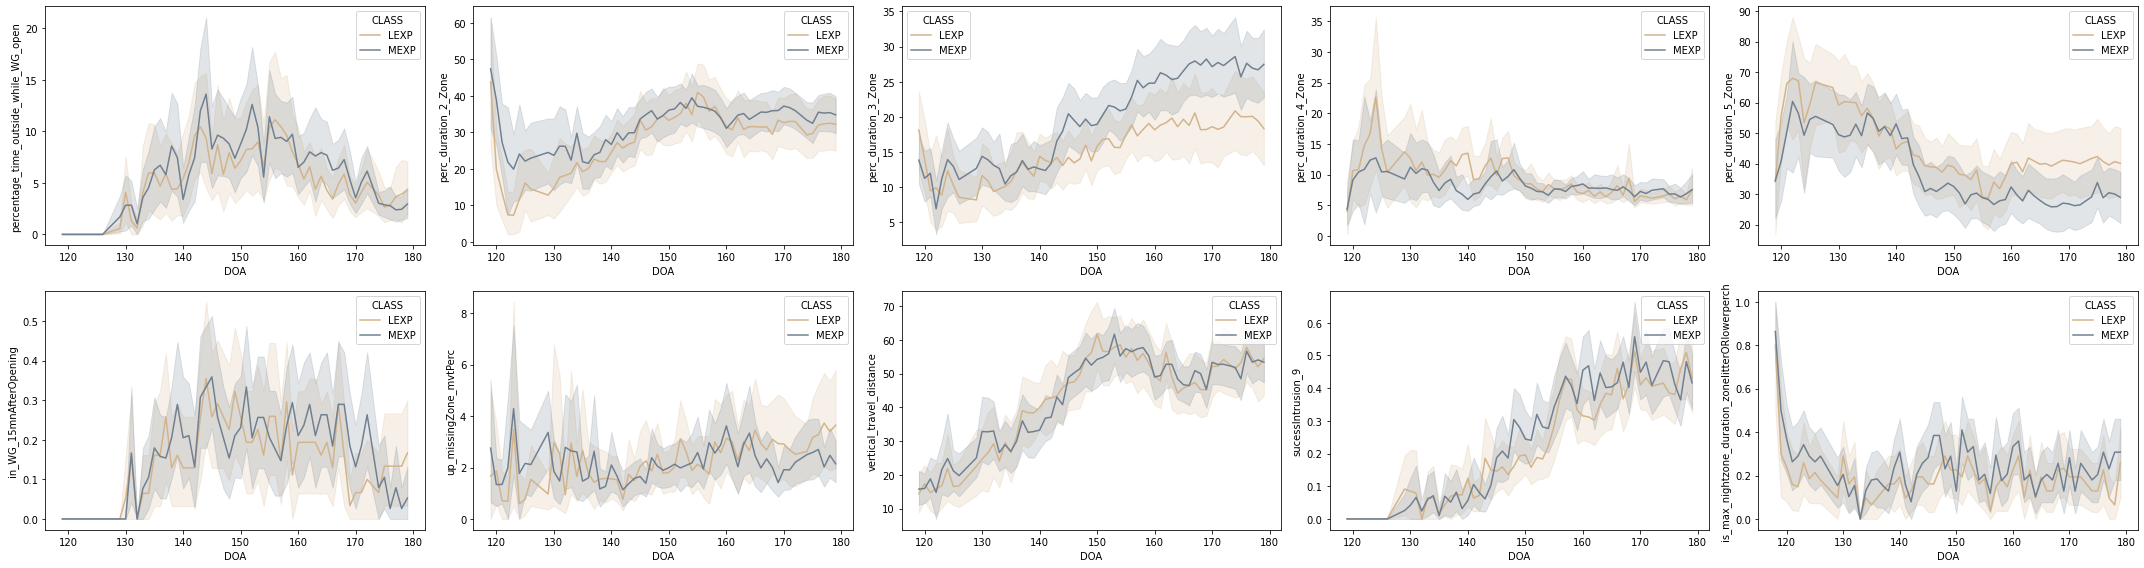

In [18]:
c = 5
l = math.ceil(len(li_all)/5) #round up
img_w = 6 
img_h = 4 
fig = plt.figure(figsize=(int(c*img_w), int(l*img_h)))
i = 1
for x in li_all:
    #print(x)
    plt.subplot(l,c,i)
    plt.tight_layout()
    df_plt = df_daily[df_daily['CLASS'].isin(['LEXP','MEXP'])][['HenID','DOA',x,'CLASS']].copy()
    df_plt = df_plt[~df_plt.isnull().any(axis=1)]
    sns.lineplot(data=df_plt, x="DOA", y=x, hue='CLASS', palette=pal_class, hue_order=['LEXP','MEXP'])
    i = i+1
plt.savefig(os.path.join(path_extracted_data_visual_adap,'CLASS_Adaptability.png'), bbox_inches='tight')
print(df_plt.shape)
display(df_plt.head(3))
plt.show();